# Kaggle GI Tract Inference 2.5 D

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer




**Notes**
* 


In [5]:
import os, glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from tqdm import tqdm

from torchvision.transforms import PILToTensor
from torchvision import transforms
from torch.nn import functional as F


ROOT_FOLDER = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/')
MODEL_FOLDER = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models')

model_file_base = 'Unet-4-1.pth'
n_folds = 5

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

# Data

#### this script is for debugging locally and uses the training data
`debug = True` will result in using all the training images to do inference and also do a check on the resize+ pad transform needed to invert the basic training transform  (crop+resize)

In [148]:
debug = True # There is no other option in this notebook

### Create a mock submission file

In [149]:
submission_mock = pd.read_csv(ROOT_FOLDER/"train.csv")

In [150]:
submission_mock.columns = ['id', 'class', 'predicted']

In [151]:
sub_df = submission_mock

In [152]:
sub_df

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


### Drop the class and predicted column

In [153]:
sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates()

## Get the metadata

In [154]:
def add_metadata(df):
    #Get Case-ID as columns (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["case_id_str"].apply(lambda x: int(x[4::]))

    #Get Day as columns (str and int)
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["day_num_str"].apply(lambda x: int(x[3::]))

    #Get Slice Identifier as columns (str and int)
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
    df["slice_num"] = df["slice_id"].apply(lambda x: int(x[6::]))

    # Create the path to get to the file
    df['match'] = df.case_id_str + '/' + df.case_id_str + '_' + df.day_num_str + '/scans/' + df.slice_id
    return 

In [155]:
add_metadata(sub_df)

In [156]:
sub_df

,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
0,case123_day20_slice_0001,case123,123,day20,20,slice_0001,1,case123/case123_day20/scans/slice_0001
3,case123_day20_slice_0002,case123,123,day20,20,slice_0002,2,case123/case123_day20/scans/slice_0002
6,case123_day20_slice_0003,case123,123,day20,20,slice_0003,3,case123/case123_day20/scans/slice_0003
9,case123_day20_slice_0004,case123,123,day20,20,slice_0004,4,case123/case123_day20/scans/slice_0004
12,case123_day20_slice_0005,case123,123,day20,20,slice_0005,5,case123/case123_day20/scans/slice_0005
...,...,...,...,...,...,...,...,...
115473,case30_day0_slice_0140,case30,30,day0,0,slice_0140,140,case30/case30_day0/scans/slice_0140
115476,case30_day0_slice_0141,case30,30,day0,0,slice_0141,141,case30/case30_day0/scans/slice_0141
115479,case30_day0_slice_0142,case30,30,day0,0,slice_0142,142,case30/case30_day0/scans/slice_0142
115482,case30_day0_slice_0143,case30,30,day0,0,slice_0143,143,case30/case30_day0/scans/slice_0143


## Process the Test files

In [157]:

test_fnames = glob.glob("{}/train/*/*/scans/*.png".format(str(ROOT_FOLDER)))  #updated
file_df = pd.DataFrame(test_fnames)
#file_df = file_df[:200*3]

### Get the filenames for the test files and make a dataframe for inference



In [158]:

print("Samples to predict:",len(file_df))

Samples to predict: 38496


In [159]:
file_df.columns = ["path"]

We need a way to get the `id` for the submission from the file paths

Build a function that does the string manipulation

In [160]:
def id_from_path(p):
    
    #p = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case24/case24_day25/scans/slice_0046_266_266_1.50_1.50.png'
    s1 = p.split('/')
    filename = s1[-1] # 'slice_0046_266_266_1.50_1.50.png'
    case_day_str = s1[-3] # 'case24_day25'
    slice_str = '_'.join(filename.split('_')[-7:-4]) #'slice_0046'
    id_str = case_day_str + '_' + slice_str #'case24_day25_slice_0046'
    return id_str
    
    

In [161]:
file_df["id"] = file_df["path"].apply(id_from_path)

In [162]:
file_df

,path,id
0,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0046
1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0099
2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0013
3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0064
4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0090
...,...,...
38491,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0049
38492,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0079
38493,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0093
38494,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0119


## Add metadata to the file info

In [163]:
add_metadata(file_df)

In [164]:
file_df

,path,id,case_id_str,case_id,day_num_str,day_num,slice_id,slice_num,match
0,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0046,case24,24,day25,25,slice_0046,46,case24/case24_day25/scans/slice_0046
1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0099,case24,24,day25,25,slice_0099,99,case24/case24_day25/scans/slice_0099
2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0013,case24,24,day25,25,slice_0013,13,case24/case24_day25/scans/slice_0013
3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0064,case24,24,day25,25,slice_0064,64,case24/case24_day25/scans/slice_0064
4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0090,case24,24,day25,25,slice_0090,90,case24/case24_day25/scans/slice_0090
...,...,...,...,...,...,...,...,...,...
38491,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0049,case29,29,day0,0,slice_0049,49,case29/case29_day0/scans/slice_0049
38492,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0079,case29,29,day0,0,slice_0079,79,case29/case29_day0/scans/slice_0079
38493,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0093,case29,29,day0,0,slice_0093,93,case29/case29_day0/scans/slice_0093
38494,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0119,case29,29,day0,0,slice_0119,119,case29/case29_day0/scans/slice_0119


### Merge the file info into the submission info

In [165]:
test_df = sub_df.merge(file_df, on='match', how='left')

In [166]:
test_df

,id_x,case_id_str_x,case_id_x,day_num_str_x,day_num_x,slice_id_x,slice_num_x,match,path,id_y,case_id_str_y,case_id_y,day_num_str_y,day_num_y,slice_id_y,slice_num_y
0,case123_day20_slice_0001,case123,123,day20,20,slice_0001,1,case123/case123_day20/scans/slice_0001,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case123_day20_slice_0001,case123,123,day20,20,slice_0001,1
1,case123_day20_slice_0002,case123,123,day20,20,slice_0002,2,case123/case123_day20/scans/slice_0002,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case123_day20_slice_0002,case123,123,day20,20,slice_0002,2
2,case123_day20_slice_0003,case123,123,day20,20,slice_0003,3,case123/case123_day20/scans/slice_0003,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case123_day20_slice_0003,case123,123,day20,20,slice_0003,3
3,case123_day20_slice_0004,case123,123,day20,20,slice_0004,4,case123/case123_day20/scans/slice_0004,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case123_day20_slice_0004,case123,123,day20,20,slice_0004,4
4,case123_day20_slice_0005,case123,123,day20,20,slice_0005,5,case123/case123_day20/scans/slice_0005,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case123_day20_slice_0005,case123,123,day20,20,slice_0005,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,case30,30,day0,0,slice_0140,140,case30/case30_day0/scans/slice_0140,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case30_day0_slice_0140,case30,30,day0,0,slice_0140,140
38492,case30_day0_slice_0141,case30,30,day0,0,slice_0141,141,case30/case30_day0/scans/slice_0141,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case30_day0_slice_0141,case30,30,day0,0,slice_0141,141
38493,case30_day0_slice_0142,case30,30,day0,0,slice_0142,142,case30/case30_day0/scans/slice_0142,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case30_day0_slice_0142,case30,30,day0,0,slice_0142,142
38494,case30_day0_slice_0143,case30,30,day0,0,slice_0143,143,case30/case30_day0/scans/slice_0143,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case30_day0_slice_0143,case30,30,day0,0,slice_0143,143


## get pixel scaling info from full 3D images

In [167]:
pil_to_tensor = transforms.ToTensor()

In [168]:
def image_max(path):
    img_path = path
    img = pil_to_tensor(Image.open(img_path))
    #stat = img.max().item()
    stat = (img.flatten()*1.0).quantile(0.75).item()
    return stat

In [169]:
#find the max pixel intensity for each image
test_df['max'] = test_df['path'].apply(image_max)

In [170]:
#group by the slice (same case_id and day_num)
#make a transform
test_df['max_img'] = test_df.groupby(['case_id_x' ,'day_num_x'])['max'].transform('max')

In [171]:
test_df.columns

Index(['id_x', 'case_id_str_x', 'case_id_x', 'day_num_str_x', 'day_num_x',
       'slice_id_x', 'slice_num_x', 'match', 'path', 'id_y', 'case_id_str_y',
       'case_id_y', 'day_num_str_y', 'day_num_y', 'slice_id_y', 'slice_num_y',
       'max', 'max_img'],
      dtype='object')

In [172]:
test_df[[ 'case_id_x',  'day_num_x','slice_num_x',  'max', 'max_img']]

,case_id_x,day_num_x,slice_num_x,max,max_img
0,123,20,1,152.00,4579.0
1,123,20,2,171.00,4579.0
2,123,20,3,209.00,4579.0
3,123,20,4,247.00,4579.0
4,123,20,5,285.00,4579.0
...,...,...,...,...,...
38491,30,0,140,1176.00,2604.0
38492,30,0,141,1092.00,2604.0
38493,30,0,142,992.25,2604.0
38494,30,0,143,903.00,2604.0


### Handle 2.5D

In [193]:
def add_neighboring_slices(df, channels=3, stride=2):    

    for i in range(channels):
        shift = (i - channels//2)*stride
        print("channel:",i, "shift:",shift)
        df[f'path_{i:02}'] = df.groupby(['case_id_x','day_num_x'])['path'].shift(-shift).fillna(value='')
    df['paths'] = df[[f'path_{i:02d}' for i in range(channels)]].values.tolist()


In [194]:
add_neighboring_slices(test_df, channels=3, stride=2)

channel: 0 shift: -2
channel: 1 shift: 0
channel: 2 shift: 2


In [195]:
test_df.columns

Index(['id_x', 'case_id_str_x', 'case_id_x', 'day_num_str_x', 'day_num_x',
       'slice_id_x', 'slice_num_x', 'match', 'path', 'id_y', 'case_id_str_y',
       'case_id_y', 'day_num_str_y', 'day_num_y', 'slice_id_y', 'slice_num_y',
       'max', 'max_img', 'path_00', 'path_01', 'path_02', 'paths'],
      dtype='object')

In [196]:
test_df.iloc[0]['path'],test_df.iloc[0]['path_00'],test_df.iloc[0]['path_01'],test_df.iloc[0]['path_02']

('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '',
 '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png')

In [197]:
test_df[['id_x', 'case_id_x', 'day_num_x', 'slice_num_x', 'match', 'path','path_00', 'path_01', 'path_02', 'paths']]

,id_x,case_id_x,day_num_x,slice_num_x,match,path,path_00,path_01,path_02,paths
0,case123_day20_slice_0001,123,20,1,case123/case123_day20/scans/slice_0001,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,"[, /media/SSD/gi-tract/uw-madison-gi-tract-ima..."
1,case123_day20_slice_0002,123,20,2,case123/case123_day20/scans/slice_0002,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,"[, /media/SSD/gi-tract/uw-madison-gi-tract-ima..."
2,case123_day20_slice_0003,123,20,3,case123/case123_day20/scans/slice_0003,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
3,case123_day20_slice_0004,123,20,4,case123/case123_day20/scans/slice_0004,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
4,case123_day20_slice_0005,123,20,5,case123/case123_day20/scans/slice_0005,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,30,0,140,case30/case30_day0/scans/slice_0140,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
38492,case30_day0_slice_0141,30,0,141,case30/case30_day0/scans/slice_0141,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
38493,case30_day0_slice_0142,30,0,142,case30/case30_day0/scans/slice_0142,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,[/media/SSD/gi-tract/uw-madison-gi-tract-image...
38494,case30_day0_slice_0143,30,0,143,case30/case30_day0/scans/slice_0143,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,,[/media/SSD/gi-tract/uw-madison-gi-tract-image...


In [198]:
test_df['path'] == test_df['path_01']

0        True
1        True
2        True
3        True
4        True
         ... 
38491    True
38492    True
38493    True
38494    True
38495    True
Length: 38496, dtype: bool

## Get the NN Models

For each fold of the data we have a model, so we need to get all of them.  They are not huge so we can keep all of them in the GPU.

In [199]:
models = []
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # don't need initialization since we will load our models
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_file_base) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()
    models.append(model)
    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-4-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-4-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-4-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-4-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-4-1.pth


## Create a Pytorch Dataset for inference

The main difference relative to training is we don't have the ground truth run length encoded mask.
We also provide the `id` used in the submission because its the key

In [228]:
class Dataset_2_5_from_df_inference(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pil_to_tensor = transforms.ToTensor()

        
    def __len__(self):
        return self.df.shape[0]
        
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        #print('test:',idx)
        
        img_path = row.path
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        #scale image using stats from whole 3D image
        img = img / (row['max_img']*5) # factor to make sure we don't clip
        
        
        # capture the shape of the original image because we want our final mask
        # used for RLE to match this shape
        mask_shape = img.shape

        img3 = torch.zeros((3, img.shape[1], img.shape[2]),dtype=torch.float32)
        
        
        img3[1,:,:] = img
        
        if len(row.path_00) > 0:
            img = self.pil_to_tensor(Image.open(row.path_00))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[0,:,:] = img
 
        if len(row.path_02) > 0:
            img = self.pil_to_tensor(Image.open(row.path_02))
            img = img / (row['max_img']*5) # factor to make sure we don't clip
            img3[2,:,:] = img
        
        
        # resize our image to a consistent size to provide as input to model
        if self.transform:
            img3 = self.transform(img3)
    
        
        
        return {
            "image": img3,
            "mask_shape": mask_shape,
            "id": row.id_x #return the row id used in the submission
        }
        
        
    
    


### Define our transform
We use the basic imaging sizing from Training because that recreates the conditions under which we trained

In [229]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')  

In [230]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [231]:
scale_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Create the Dataset
And ensure it returns what we expect

In [232]:
test_dataset = Dataset_2_5_from_df_inference(test_df,scale_transforms)

In [233]:
test_dataset[0]['mask_shape'], test_dataset[0]['id']

(torch.Size([1, 266, 266]), 'case123_day20_slice_0001')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


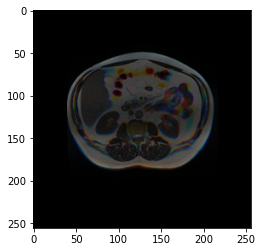

In [234]:
plt.imshow(rearrange(test_dataset[100]['image'].numpy(),'c h w -> h w c'), vmin=0, vmax=1.0)


## Inference Processing

Create the dataloader. Kaggle reccommends `num_workers=2` when using the GPU.  We may have to change the `batch_size` and `pin_memory` settings for Kaggle virtual machine.

In [235]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               pin_memory=True, #pagelock the memory for faster loads to GPU RAM
                                               shuffle=False)

In [236]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Threshold for turning the masking image prediction into an image with pixels of 0 or 1 per channel
Reflects how high we need the predicted probababilty before we count the pixel in the mask
Also the image resizing impacts the mask edges (we use bicubic interpolation to avoid some of this) so a lower threshold might be needed to have the masks with pixels of 0 or 1 register edges better.

Should be between 0 and 1.0, on the higher side.

In [237]:

threshold = .8

Loop through our test data and create the submission

In [238]:
sub = {'id':[], 'class':[], 'predicted':[]} # a dict to store our submission
pbar = tqdm(total=len(test_dataloader))


for batch in test_dataloader:
    
    images = batch['image'].to(DEVICE)
    mask_shape = batch['mask_shape']
    ids = batch['id']
    

    #Take each of our fold models and average the outputs together
    with torch.no_grad():
        output = models[0](images)
        output = torch.nn.Sigmoid()(output) / n_folds
        mask = output
        for i in range(1,n_folds):
            output = models[i](images)
            output = torch.nn.Sigmoid()(output) / n_folds
            mask = mask + output
    
    #print("1", mask.shape)


    #From here we need to apply the invert of the the basic image crop and resize exactly to the mask image
    #and then apply run length encoding to that image
    
    mask = transforms.Resize((360,360),interpolation=transforms.InterpolationMode.BICUBIC)(mask) # undo resize to 288x288
    #print("3", mask.shape)
    
    #print('4',mask_shape)
    
    
    # Since we are processing a batch, the final mask shape may change within a batch
    # So we can't store that as a 1 tensor per batch
    # Need to process each batch item individually from here

    #single_mask = torch.zeros_like(mask[0])
    batch_size = mask.shape[0]  # need to get for each batch since last batch may smaller
    for b in range(0,batch_size):
        
        #plt.imshow(rearrange(mask[b].cpu().detach().numpy(),'c h w -> h w c'))
        #print('here',(mask_shape[1][b].item(),mask_shape[2][b].item()))
        
        
        single_mask = transforms.functional.center_crop(mask[b],(mask_shape[1][b].item(),mask_shape[2][b].item()))
        
        #print("5", single_mask.shape)
            
        single_mask = (single_mask > threshold)*1.0  # Run Length encoding requires a mask with 0 or 1
        single_mask = single_mask.cpu().detach().numpy() # go from a tensor on the GPU to a numpy on CPU

        #plt.imshow(rearrange(single_mask,'c h w -> h w c'))
        # create 3 submission rows, one for each organ
        sub_id = ids[b] #get the submission id from the batch
        
        large_bowel = rle_encode(single_mask[0])
        sub['id'].append(sub_id)
        sub['class'].append('large_bowel')
        sub['predicted'].append(large_bowel)

        small_bowel = rle_encode(single_mask[1])
        sub['id'].append(sub_id)
        sub['class'].append('small_bowel')
        sub['predicted'].append(small_bowel)

        stomach = rle_encode(single_mask[2])
        sub['id'].append(sub_id)
        sub['class'].append('stomach')
        sub['predicted'].append(stomach)    

    

        
   
    pbar.update(1)
    #break
pbar.close()
torch.cuda.empty_cache()



  2%|▋                                        | 44/2406 [00:57<51:20,  1.30s/it]

  4%|█▋                                       | 96/2406 [00:20<08:05,  4.76it/s]


  8%|███▏                                    | 193/2406 [00:40<07:33,  4.88it/s]


 12%|████▊                                   | 290/2406 [01:01<07:28,  4.72it/s]


 16%|██████▍                                 | 387/2406 [01:21<06:54,  4.87it/s]


 20%|████████                                | 484/2406 [01:42<06:40,  4.80it/s]


 24%|█████████▋                              | 581/2406 [02:02<06:16,  4.85it/s]


 28%|███████████▎                            | 678/2406 [02:22<06:08,  4.69it/s]


 32%|████████████▉                           | 775/2406 [02:43<05:42,  4.76it/s]


 36%|██████████████▍                         | 872/2406 [03:04<05:43,  4.47it/s]


 40%|████████████████                        | 969/2406 [03:25<05:01,  4.77it/s]


 44%|█████████████████▎                     | 1066/2406 [03:45<04:45,  4.69it/s]


 48%|██████████████████▊                    | 1163/2406 [04:06<04:23,  4.71it/s]


 52%|████████████████████▍                  | 1260/2406 [04:27<04:10,  4.57it/s]


 56%|█████████████████████▉                 | 1357/2406 [04:48<03:42,  4.72it/s]


 60%|███████████████████████▌               | 1454/2406 [05:09<03:26,  4.62it/s]


 64%|█████████████████████████▏             | 1551/2406 [05:29<03:01,  4.71it/s]


 68%|██████████████████████████▋            | 1648/2406 [05:50<02:45,  4.58it/s]


 73%|████████████████████████████▎          | 1745/2406 [06:11<02:19,  4.75it/s]


 77%|█████████████████████████████▊         | 1842/2406 [06:32<01:58,  4.75it/s]


 81%|███████████████████████████████▍       | 1939/2406 [06:52<01:38,  4.76it/s]


 85%|█████████████████████████████████      | 2036/2406 [07:13<01:18,  4.71it/s]


 89%|██████████████████████████████████▌    | 2133/2406 [07:33<01:01,  4.46it/s]


 93%|████████████████████████████████████▏  | 2230/2406 [07:54<00:37,  4.64it/s]


 97%|█████████████████████████████████████▋ | 2327/2406 [08:15<00:17,  4.61it/s]


100%|███████████████████████████████████████| 2406/2406 [08:32<00:00,  4.69it/s]


### Create predictions

In [247]:
pred_df = pd.DataFrame(sub)

In [250]:
(pred_df['predicted'] == '').sum()

82350

In [251]:
# replace NaNs with an empty string for the 'predicted' column
pred_df.predicted = pred_df.predicted.fillna('')

In [258]:
pred_df

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,
115484,case30_day0_slice_0143,stomach,
115485,case30_day0_slice_0144,large_bowel,
115486,case30_day0_slice_0144,small_bowel,


In [252]:
submission_mock = pd.read_csv(ROOT_FOLDER/"train.csv")

In [253]:
submission_mock.columns = ['id', 'class', 'predicted']

In [256]:
submission_mock = submission_mock.drop(columns=['predicted'])

In [257]:
submission_mock

,id,class
0,case123_day20_slice_0001,large_bowel
1,case123_day20_slice_0001,small_bowel
2,case123_day20_slice_0001,stomach
3,case123_day20_slice_0002,large_bowel
4,case123_day20_slice_0002,small_bowel
...,...,...
115483,case30_day0_slice_0143,small_bowel
115484,case30_day0_slice_0143,stomach
115485,case30_day0_slice_0144,large_bowel
115486,case30_day0_slice_0144,small_bowel


In [259]:

submission_mock = submission_mock.merge(pred_df, on=['id','class'])

In [260]:
submission_mock

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,
115484,case30_day0_slice_0143,stomach,
115485,case30_day0_slice_0144,large_bowel,
115486,case30_day0_slice_0144,small_bowel,


In [263]:
sel = submission_mock['predicted'] ==''

In [264]:
submission_mock[~sel]

,id,class,predicted
197,case123_day20_slice_0066,stomach,27824 6 28089 9 28353 13 28619 13 28885 14 291...
200,case123_day20_slice_0067,stomach,23837 1 24100 6 24365 8 24630 9 24895 11 25160...
203,case123_day20_slice_0068,stomach,15588 6 15852 9 16117 11 16383 11 16648 13 169...
206,case123_day20_slice_0069,stomach,14790 3 15054 9 15319 11 15584 13 15849 15 161...
209,case123_day20_slice_0070,stomach,14257 3 14521 8 14785 13 15050 16 15315 17 155...
...,...,...,...
115459,case30_day0_slice_0135,small_bowel,24138 5 24676 2 24933 1 24945 1 25198 1 25727 ...
115461,case30_day0_slice_0136,large_bowel,19021 4 19270 9 19291 6 19303 8 19315 1 19534 ...
115462,case30_day0_slice_0136,small_bowel,24933 8 25725 3 25744 2 25987 5 26012 2 26279 ...
115464,case30_day0_slice_0137,large_bowel,19009 10 19268 5 19286 7 19532 3 19558 6 19574...


# Compare with ground truth

In [276]:
pivoted = submission_mock.pivot(index="id", columns="class", values="predicted")

In [277]:
df2d = pd.read_csv(ROOT_FOLDER/"df2d_metadata.csv",index_col = [0])

In [278]:
pivoted = pivoted.merge(df2d[['id','subpath','im_width','im_height','large_bowel','small_bowel','stomach']],on='id',how='left')


In [279]:
pivoted

,id,large_bowel_x,small_bowel_x,stomach_x,subpath,im_width,im_height,large_bowel_y,small_bowel_y,stomach_y
0,case101_day20_slice_0001,,,,case101/case101_day20/scans/slice_0001_266_266...,266,266,NaN,NaN,NaN
1,case101_day20_slice_0002,,,,case101/case101_day20/scans/slice_0002_266_266...,266,266,NaN,NaN,NaN
2,case101_day20_slice_0003,,,,case101/case101_day20/scans/slice_0003_266_266...,266,266,NaN,NaN,NaN
3,case101_day20_slice_0004,,,,case101/case101_day20/scans/slice_0004_266_266...,266,266,NaN,NaN,NaN
4,case101_day20_slice_0005,,,,case101/case101_day20/scans/slice_0005_266_266...,266,266,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,case9/case9_day22/scans/slice_0140_360_310_1.5...,310,360,NaN,NaN,NaN
38492,case9_day22_slice_0141,,,,case9/case9_day22/scans/slice_0141_360_310_1.5...,310,360,NaN,NaN,NaN
38493,case9_day22_slice_0142,,,,case9/case9_day22/scans/slice_0142_360_310_1.5...,310,360,NaN,NaN,NaN
38494,case9_day22_slice_0143,,,,case9/case9_day22/scans/slice_0143_360_310_1.5...,310,360,NaN,NaN,NaN


In [289]:
import segmentation_models_pytorch as smp

JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [282]:
def _rle_decode_float(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    img = torch.zeros(shape[1]*shape[2])
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)    

In [295]:
list_len = pivoted.shape[0]
pbar = tqdm(total=list_len)

validation_loss = 0
metric = 0

for idx in range(0,list_len):
    row = pivoted.iloc[idx]
    
    im_shape = (1,row.im_width, row.im_height)
    
    mask = torch.zeros((3, im_shape[1], im_shape[2]))
    
    
    lb_class_seg = row.large_bowel_x
    sb_class_seg = row.small_bowel_x
    st_class_seg = row.stomach_x

    if type(lb_class_seg) is str:
        mask[0,:,:] = _rle_decode_float(lb_class_seg,im_shape,color_val=1)

    if type(sb_class_seg) is str:
        mask[1,:,:] = _rle_decode_float(sb_class_seg, im_shape,color_val=1)

    if type(st_class_seg) is str:
        mask[2,:,:] = _rle_decode_float(st_class_seg, im_shape,color_val=1)    
    
    maskg = torch.zeros((3, row.im_width, row.im_height))
    
    
    lb_class_seg = row.large_bowel_y
    sb_class_seg = row.small_bowel_y
    st_class_seg = row.stomach_y

    if type(lb_class_seg) is str:
        maskg[0,:,:] = _rle_decode_float(lb_class_seg,im_shape,color_val=1)

    if type(sb_class_seg) is str:
        maskg[1,:,:] = _rle_decode_float(sb_class_seg, im_shape,color_val=1)

    if type(st_class_seg) is str:
        maskg[2,:,:] = _rle_decode_float(st_class_seg, im_shape,color_val=1)        
    
    mask = mask.unsqueeze(0)
    maskg = maskg.unsqueeze(0)
    
    loss = criterion(mask,maskg)
    validation_loss += loss.data.item()
    
    metric += dice_coef(maskg,mask)
    
    pbar.update(1)
    
    
        
pbar.close()   
    
validation_loss /= list_len
metric /= list_len    

   
    
    

100%|████████████████████████████████████| 38496/38496 [01:17<00:00, 499.42it/s]


In [296]:
validation_loss, metric

(0.48582900739766516, tensor(0.9065))

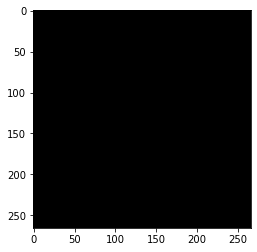

In [286]:
plt.imshow(rearrange(mask.numpy(),'c h w -> h w c'), vmin=0, vmax=1.0)

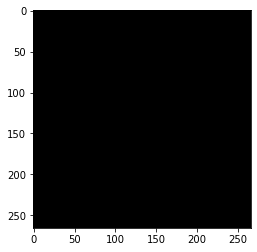

In [287]:
plt.imshow(rearrange(maskg.numpy(),'c h w -> h w c'), vmin=0, vmax=1.0)